# Analyze the loss based on the simulations runtime

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

#os.environ['JAX_PLATFORM_NAME'] = "cpu"
#os.environ['JAX_PLATFORMS'] = "cpu"

In [2]:
import jax.numpy as jnp
import jax

import numpy as onp

import matplotlib.pyplot as plt

from simulation.simulate_full import run_entire_simulation

from analyzers import defaultvalues as dv, database, loss as loss_anaylzer

/home/florian/anaconda3/envs/jaxidp/lib/python3.11/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [3]:
scan_space = jnp.linspace(3.0000, 3.0001, 8)
nq_values = onp.array(onp.linspace(30, 300, 30), dtype=int)

In [4]:
def get_sim_result(lj_sigma_oo, n_q):
    return run_entire_simulation(lj_sigma_oo, dv.N_STEPS, dv.N_MOLECULES_PER_AXIS, dv.N_SNAPSHOTS, n_q, 1)

In [5]:
database.set_filename("../data/loss_analyzer/nq_scan.npz")

Calculate losses over the scan space for each runtime from the array

In [ ]:
all_losses = []

for n_qs in nq_values:
    existing_keys = database.get_existing_keys()
    if n_qs in existing_keys:
        print(f"Skipping {n_qs}, was already computed")
        continue

    print(f"=== Running for {n_qs} Q-Values ===")
    reference = get_sim_result(dv.LJ_SIGMA_OO, n_qs)
    losses = jax.vmap(lambda lj_sigma_oo: loss_anaylzer.L1_loss(get_sim_result(lj_sigma_oo, n_qs), reference))(scan_space)
            
    jitter = loss_anaylzer.get_loss_jitter(losses)
    print(f"Jitter: {jitter}")

    database.save_intermediate_result(n_qs, losses)

# Plot
Skip previous if data is already available

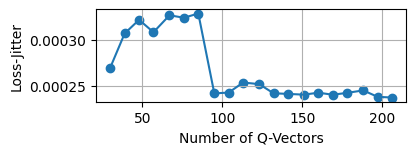

[0.000269644160308231, 0.0003069897902595524, 0.0003219434487244955, 0.0003083516746599435, 0.0003268911034052424, 0.00032419843174451887, 0.0003288063648992668, 0.0002414662702924301, 0.00024245916328852825, 0.0002533778792265868, 0.00025164401379715225, 0.00024162903551079858, 0.0002409693650243515, 0.0002401324350574272, 0.00024228225122881696, 0.00024003762187307164, 0.00024212664281122027, 0.00024477021238186394, 0.00023775246701000582, 0.00023699768059986005]


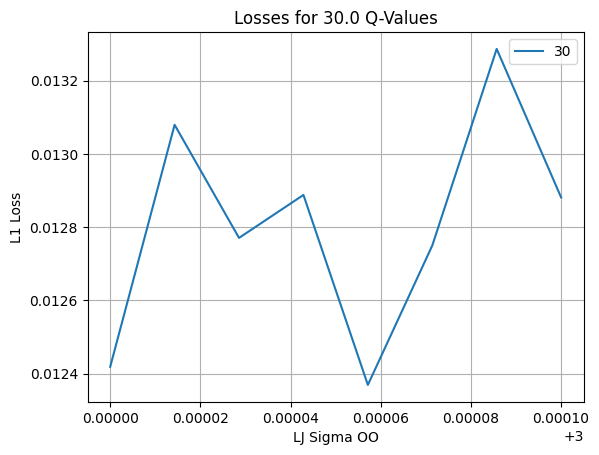

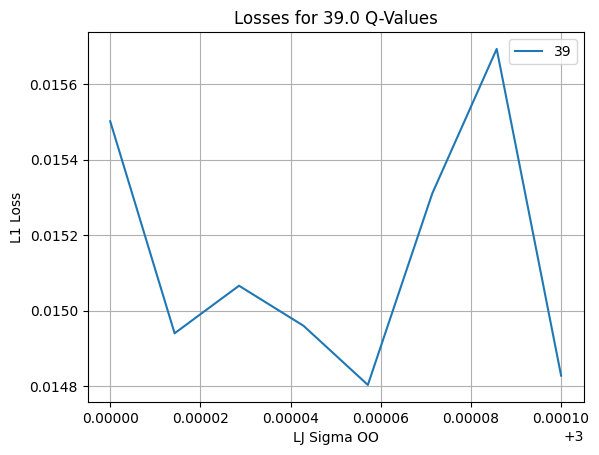

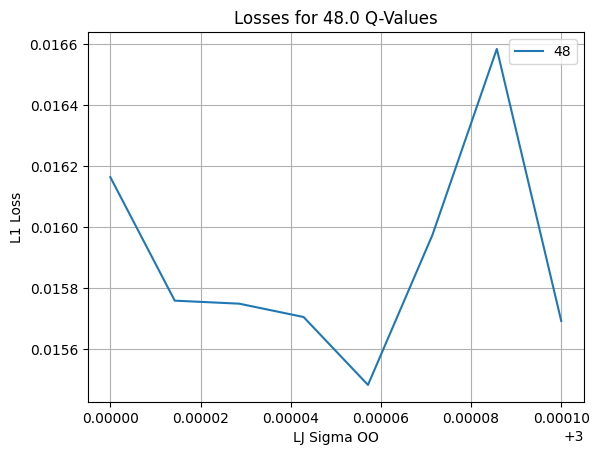

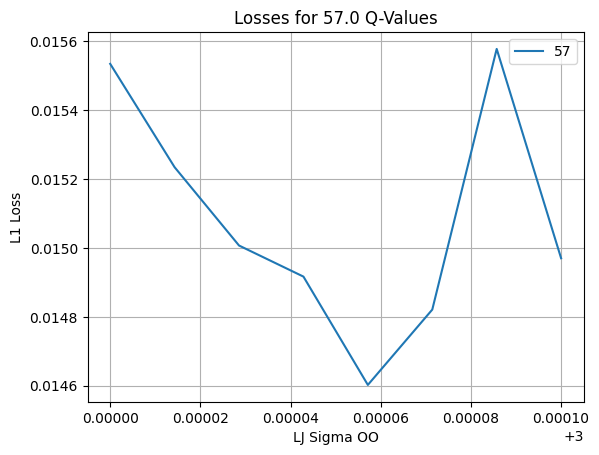

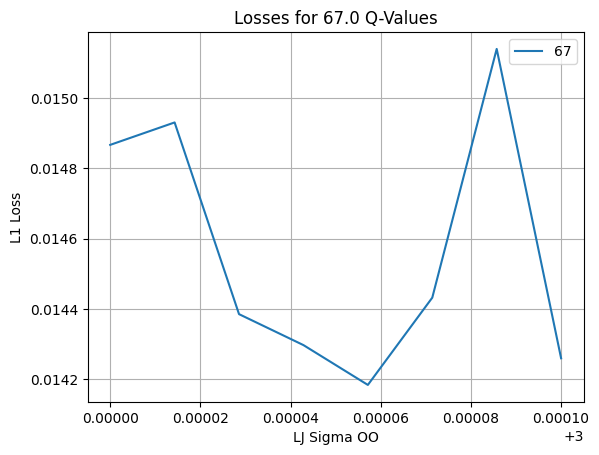

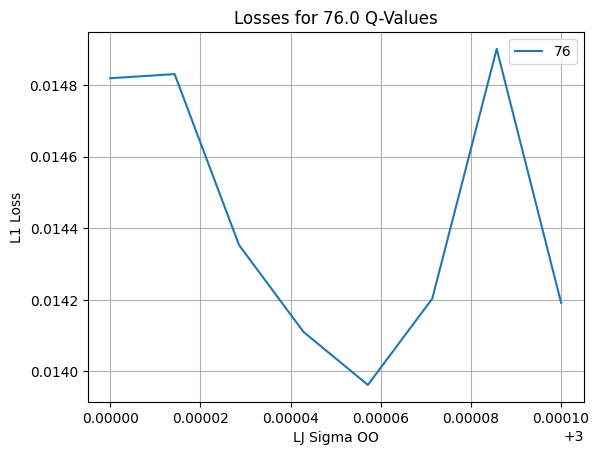

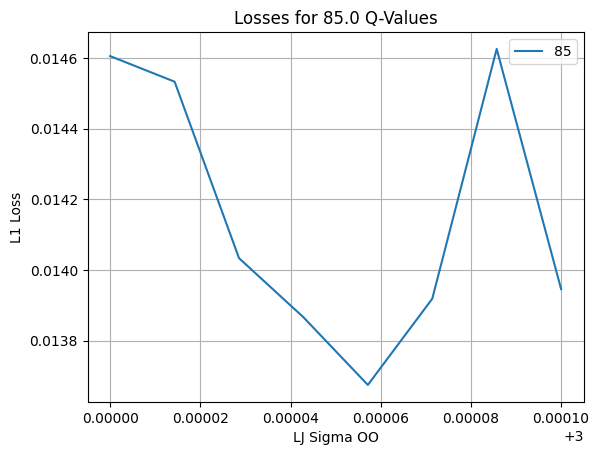

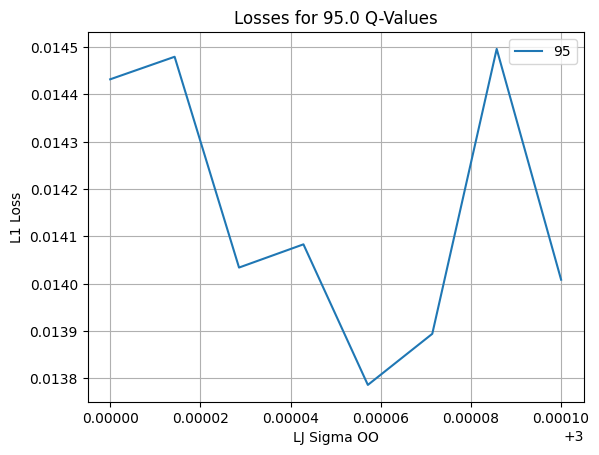

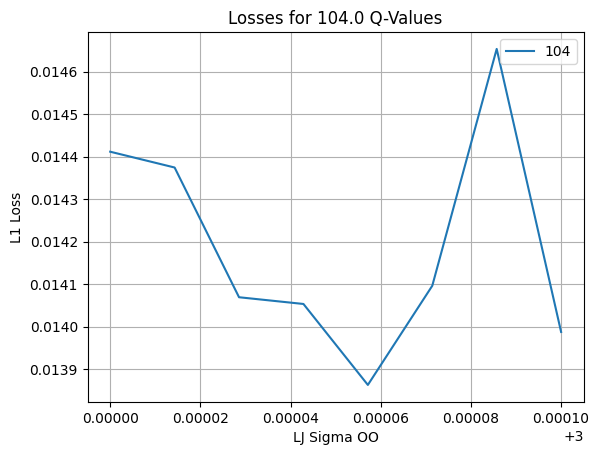

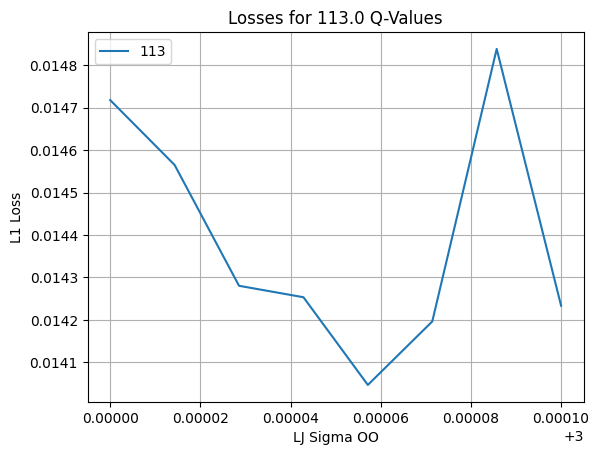

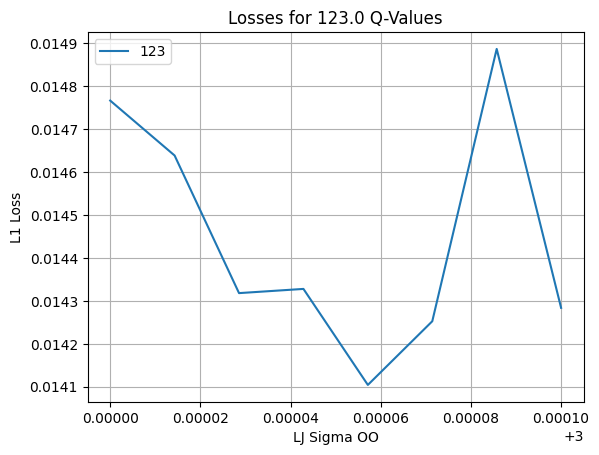

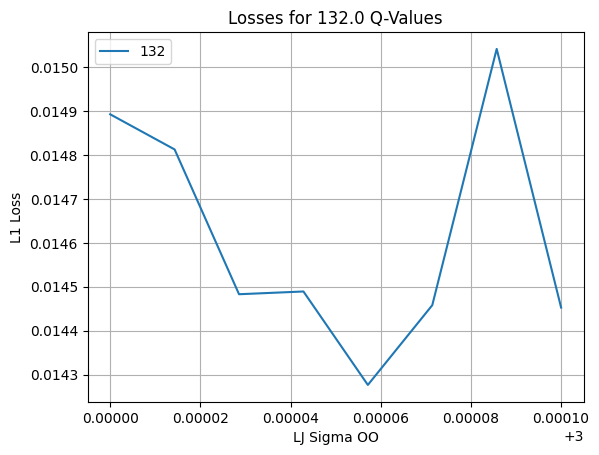

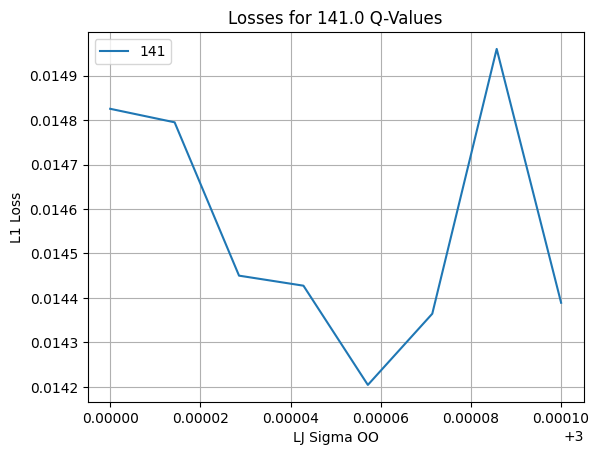

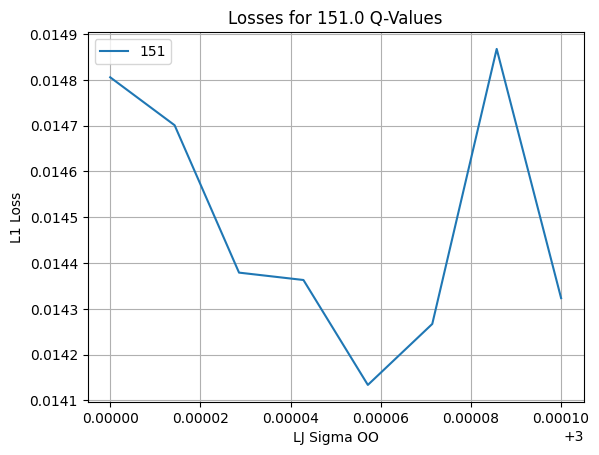

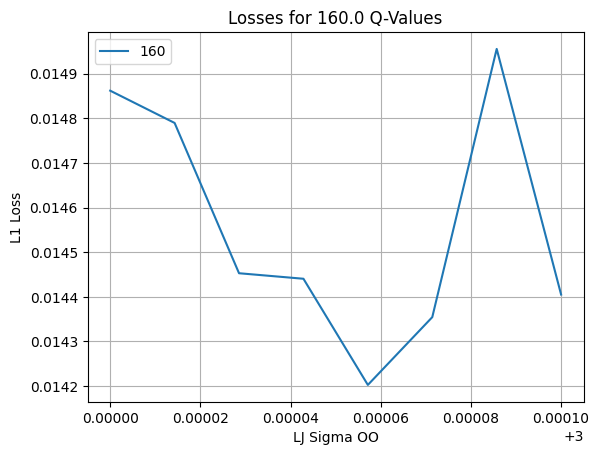

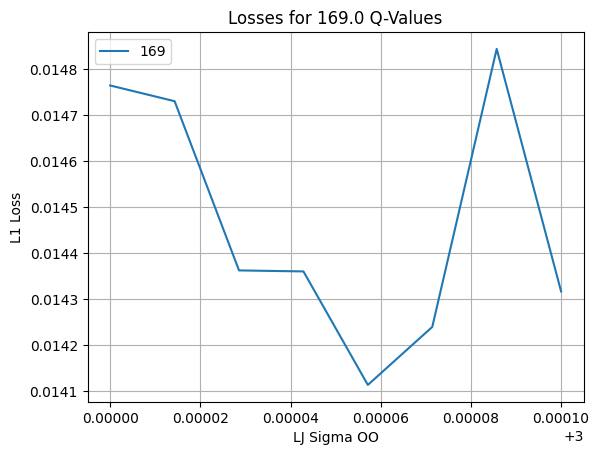

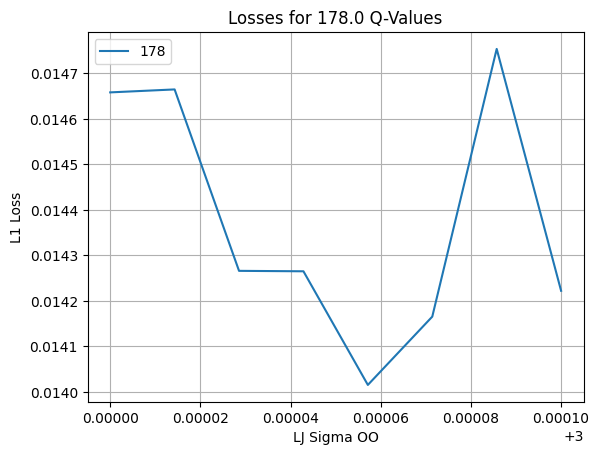

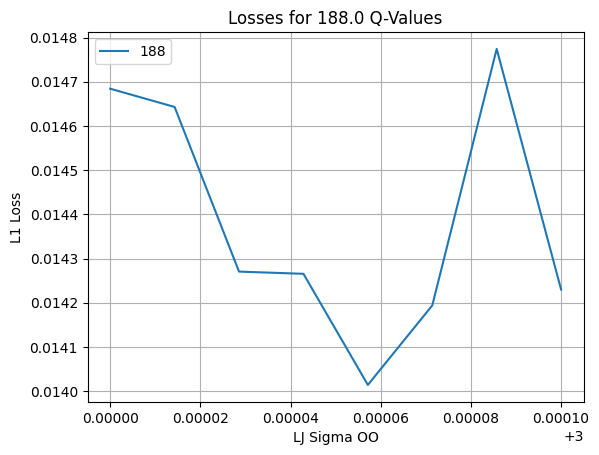

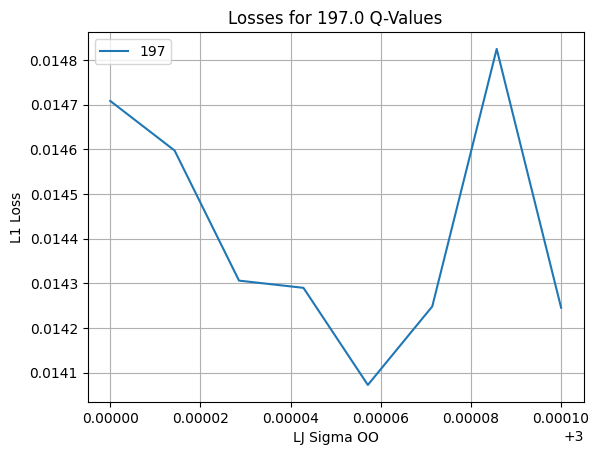

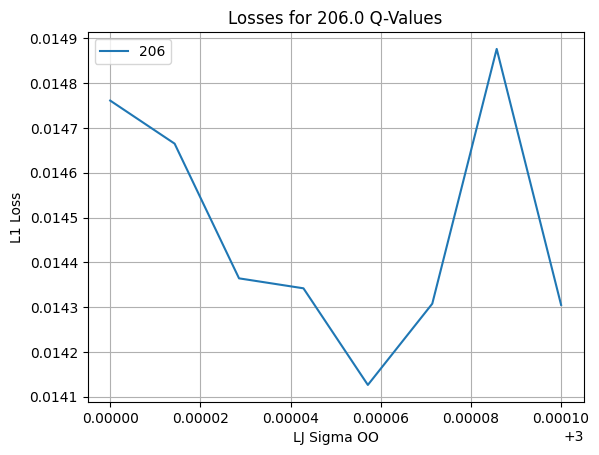

In [6]:
keys, values = database.load_result()
jitter_values = [loss_anaylzer.get_loss_jitter(v) for v in values]

plt.plot(keys, jitter_values)
plt.scatter(keys, jitter_values)
plt.xlabel("Number of Q-Vectors")
plt.ylabel("Loss-Jitter")

plt.grid()
plt.gcf().set_size_inches(4, 1.2)
plt.savefig("../plots/analysis_loss_nq.svg")
plt.show()

print(jitter_values)

for i, x in enumerate(values):
    plt.plot(scan_space, x, label=f"{nq_values[i]}")
    plt.legend()
    plt.xlabel("LJ Sigma OO")
    plt.ylabel("L1 Loss")
    plt.title(f"Losses for {keys[i]} Q-Values")
    plt.grid()
    plt.show()